## Using sklearn library for convolutional neural network

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import PIL
import matplotlib.pyplot as plt
from typing import Tuple
from tqdm import tqdm
from PIL import Image
from helper_func import load_image, PIL_resize, PIL_resize_ws
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from helper_func import generate_confusion_matrix

In [15]:
train = pd.read_csv('garbage-classification/zero-indexed-files.csv')
data = []
labels = train['Label'].values
for i in tqdm(range(train.shape[0])):
    img = load_image('garbage-classification/data/'+train['Name'][i]+'.jpg')
    img = PIL_resize_ws(img, 128)
    data.append(img)
data = np.asarray(data)
print("Training data size: ", data.shape)
print("Training label size: ", labels.shape)

100%|██████████| 2527/2527 [00:13<00:00, 183.69it/s]


Training data size:  (2527, 128, 128, 3)
Training label size:  (2527,)


## Generating training dataset and testing dataset based on a custom ratio

In [16]:
num_classified = 6
classified_name = ["glass", "paper", "cardboard", "plastic", "metal", "trash"]

classified_start_idx = np.zeros(num_classified, dtype=int)
classified_size = np.zeros(num_classified, dtype=int)
temp_count = 0
for i in range(num_classified):
    classified_start_idx[i] = temp_count
    size = np.count_nonzero(labels == i)
    classified_size[i] = size
    temp_count += size

## Defining the split between training dataset and testing dataset
training_ratio = 0.9
training_data_size = np.array(training_ratio*classified_size, dtype=int)
testing_data_size = classified_size - training_data_size

## Randomly select (num*training_ratio) from each classes in order to prevent one class from dominating the dataset by accident
training_idx = np.array([], dtype=int)
testing_idx = np.array([], dtype=int)
for i in range(num_classified):
    selected = np.random.choice(classified_size[i],size=training_data_size[i],  replace=False)
    each = np.arange(classified_size[i])
    training_idx = np.concatenate((training_idx, selected+classified_start_idx[i]), axis=0)
    testing_idx = np.concatenate((testing_idx, np.setdiff1d(each, selected)+classified_start_idx[i]), axis=0)

## Randomly shuffle the indices we pick
training_idx = np.random.permutation(training_idx)
testing_idx = np.random.permutation(testing_idx)

labels = train['Label'].values
training_data = data[training_idx]
training_labels = labels[training_idx]
testing_data = data[testing_idx]
testing_labels = labels[testing_idx]

## convert shape (N,H,W,C) to (N,C,H,W)
training_data = np.swapaxes(training_data, 1,3)
training_data = np.swapaxes(training_data, 2,3)
testing_data = np.swapaxes(testing_data, 1,3)
testing_data = np.swapaxes(testing_data, 2,3)

## Convert numpy to torch tensor
training_data = torch.from_numpy(training_data)
training_labels = torch.from_numpy(training_labels)
testing_data = torch.from_numpy(testing_data)
testing_labels = torch.from_numpy(testing_labels)
print("Training data shape: ", training_data.shape)
print("Training labels shape: ", training_labels.shape)
print("Testing data shape: ", testing_data.shape)
print("Testing labels shape: ", testing_labels.shape)

## In order to fit to sklearn MLP, we need to flatten the image
r_training_data = torch.reshape(training_data, (training_data.shape[0], -1))
r_testing_data = torch.reshape(testing_data, (testing_data.shape[0], -1))

Training data shape:  torch.Size([2271, 3, 128, 128])
Training labels shape:  torch.Size([2271])
Testing data shape:  torch.Size([256, 3, 128, 128])
Testing labels shape:  torch.Size([256])


In [17]:
from sklearn.neural_network import MLPClassifier

hidden_layer_range = [20, 30, 40, 50, 60, 70, 80, 90, 100]

losses = []
accuracies = []

for i in tqdm((hidden_layer_range)):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=20)
    clf.fit(r_training_data, training_labels)
    loss = clf.loss_
    losses.append(loss)
    
    plt.figure()
    predict = clf.predict(r_testing_data)
    predict = torch.from_numpy(predict)
    generate_confusion_matrix(testing_labels, predict, classified_name, normalize=True)
    plt.title("Confusion map of " + str(i))
    plt.show()
    matches = testing_labels[testing_labels==predict]
    accuracy = matches.shape[0]/testing_labels.shape[0]
    accuracies.append(accuracy)
    print("#hidden units "+ str(i) + "\tLoss: ", loss)
    print("#hidden units "+ str(i) + "\tAccuracy: ", accuracy)
    
plt.figure()
plt.xlabel("Hidden units")
plt.ylabel("Loss")
plt.plot(hidden_layer_range, losses)
print("Overall losses:", losses)

plt.figure()
plt.xlabel("Hidden units")
plt.ylabel("Accuracy")
plt.plot(hidden_layer_range, accuracies)
print("Overall accuracies:", accuracies)

  0%|          | 0/9 [03:32<?, ?it/s]


KeyboardInterrupt: 

In the following area, we use the best number of hidden unit output with different numbers of hidden layers and observe the result


  0%|          | 0/4 [00:00<?, ?it/s]

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

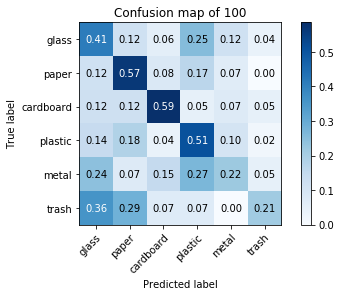


 25%|██▌       | 1/4 [24:57<1:14:52, 1497.65s/it]

#hidden layer 100	Loss:  0.5941302364433471
#hidden layer 100	Accuracy:  0.453125
Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

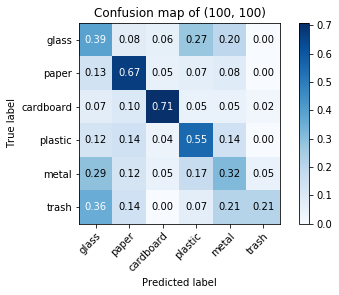


 50%|█████     | 2/4 [34:56<40:55, 1227.90s/it]  

#hidden layer (100, 100)	Loss:  0.7171783549054485
#hidden layer (100, 100)	Accuracy:  0.515625
Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

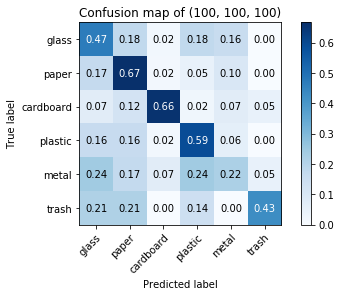


 75%|███████▌  | 3/4 [43:36<16:55, 1015.50s/it]

#hidden layer (100, 100, 100)	Loss:  0.8715512822793057
#hidden layer (100, 100, 100)	Accuracy:  0.52734375
Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

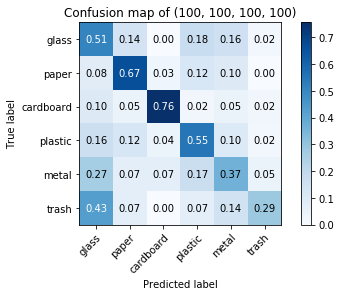

100%|██████████| 4/4 [1:06:03<00:00, 990.79s/it] 

#hidden layer (100, 100, 100, 100)	Loss:  0.6177772879195824
#hidden layer (100, 100, 100, 100)	Accuracy:  0.55859375
Overall losses: [0.5941302364433471, 0.7171783549054485, 0.8715512822793057, 0.6177772879195824]
Overall accuracies: [0.453125, 0.515625, 0.52734375, 0.55859375]


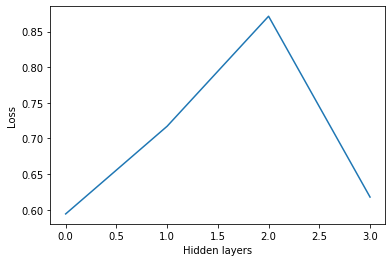

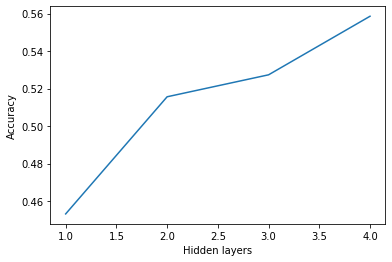

In [5]:

num_hidden_unit = hidden_layer_range[np.argmax(accuracies)]

num_hidden_layer = ((num_hidden_unit),
                    (num_hidden_unit,num_hidden_unit),
                    (num_hidden_unit,num_hidden_unit,num_hidden_unit),
                    (num_hidden_unit,num_hidden_unit,num_hidden_unit,num_hidden_unit))

losses = []
accuracies = []

for i in tqdm((num_hidden_layer)):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=i)
    clf.fit(r_training_data, training_labels)
    loss = clf.loss_
    losses.append(loss)
    
    plt.figure()
    predict = clf.predict(r_testing_data)
    predict = torch.from_numpy(predict)
    generate_confusion_matrix(testing_labels, predict, classified_name, normalize=True)
    plt.title("Confusion map of " + str(i))
    plt.show()
    matches = testing_labels[testing_labels==predict]
    accuracy = matches.shape[0]/testing_labels.shape[0]
    accuracies.append(accuracy)
    print("#hidden layer "+ str(i) + "\tLoss: ", loss)
    print("#hidden layer "+ str(i) + "\tAccuracy: ", accuracy)
    
plt.figure()
plt.xlabel("Hidden layers")
plt.ylabel("Loss")
plt.plot(np.arange(len(num_hidden_layer)), losses)
print("Overall losses:", losses)

plt.figure()
plt.xlabel("Hidden layers")
plt.ylabel("Accuracy")
plt.plot(np.arange(1, len(num_hidden_layer)+1), accuracies)
print("Overall accuracies:", accuracies)
